# Practice Finite Difference 1D

* A general diffusion equation is
$$
{\rm div}(k\, \nabla u) = f
$$
* Here $k$ is typically a scalar **diffusion coefficient** that can depends on coordinates

* Suppose we have 1D stationary diffusion problem:
$$
\begin{align*}
(k(x)\, u'(x))' &= 0 \quad \text{for }x \in [0, 1] \\
k(x) &= 1 + x \\
u_0 &= 
 \begin{cases}
   0, \quad x = 0 \\
   1, \quad x = 1
 \end{cases} \\
\end{align*}
$$


* There is an exact solution (proof):
$$
u(x) = \frac{\log{(1+x)}}{\log 2} 
$$

### Let's do it numerically

* We need to discretize the operators 

* Recall that for $g=g(x)$,
$$
\begin{align*}
\left(\frac{d}{dx}\right)_{+}g(x+h/2) &= \frac{g(x+h/2)-g(x)}{h} + O(h^2)\\
\left(\frac{d}{dx}\right)_{-}g(x-h/2) &= \frac{g(x)-g(x-h/2)}{h} + O(h^2)\\
\end{align*}
$$

* But we can increase accuracy by combining them:
$$
\frac{d^2 g}{dx^2} = \left(\frac{d}{dx}\right)_{-}\left(\frac{d}{dx}\right)_{+}g =  \frac{g(x-h)-2g(x)+g(x+h)}{h^2} + O(h^2)
$$

* So we discretize the equation this way:
$$
D_{m} K(x+h/2) D \ \vec{u(ih)} = \vec{u_0(ih)} \quad \text{for } i \in [0, n]
$$
where 
* $h = \frac{1}{n}$ is a width of $n$ uniformly distributed intervals
* $D$    is a forward-difference operator
* $D_m$   is a backward-difference operator
* $K$    is a diffusion coefficient operator


In [1]:
import numpy as np
import scipy as sp
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

In [2]:
def k(x):
    return (1+x)

### Derivative discretized operators

In [3]:
def D(n):
    h = 1/n
    T = csr_matrix((np.ones(n),(np.arange(0,n),np.arange(1,n+1))))
    return (T-sp.sparse.csr_matrix((np.ones(n),
                                    (np.arange(0,n),np.arange(0,n))),
                        shape=(n,n+1)))/h
def Dm(n):
    h = 1/n
    T = csr_matrix((np.ones(n-1),(np.arange(0,n-1),np.arange(1,n))))
    return (T-sp.sparse.csr_matrix((np.ones(n-1),
                                    (np.arange(0,n-1),np.arange(0,n-1))),
                        shape=(n-1,n)))/h

In [18]:
n=4

In [19]:
D(n).toarray() / n

array([[-1.,  1.,  0.,  0.,  0.],
       [ 0., -1.,  1.,  0.,  0.],
       [ 0.,  0., -1.,  1.,  0.],
       [ 0.,  0.,  0., -1.,  1.]])

In [20]:
Dm(n).toarray() / n

array([[-1.,  1.,  0.,  0.],
       [ 0., -1.,  1.,  0.],
       [ 0.,  0., -1.,  1.]])

In [21]:
Dm(n)*D(n).toarray() / n**2

array([[ 1., -2.,  1.,  0.,  0.],
       [ 0.,  1., -2.,  1.,  0.],
       [ 0.,  0.,  1., -2.,  1.]])

### Diffusion coefficient operator

In [8]:
def K(n):
    h = 1/n
    # Mesh of inner points
    mesh = np.linspace(h/2,1-h/2,n)
    return csr_matrix(([k(x) for x in mesh],
                      (np.arange(0,n),np.arange(0,n))))

In [9]:
K(n).toarray()

array([[1.125, 0.   , 0.   , 0.   ],
       [0.   , 1.375, 0.   , 0.   ],
       [0.   , 0.   , 1.625, 0.   ],
       [0.   , 0.   , 0.   , 1.875]])

### Discretized equation matrix

In [10]:
def A(n):
    return sp.sparse.vstack([
        csr_matrix(([1],([0],[0])),shape=(1,n+1)),
        Dm(n)*(K(n)*D(n)),
        csr_matrix(([1],([0],[n])),shape=(1,n+1))])

In [11]:
A(n).toarray()

array([[  1.,   0.,   0.,   0.,   0.],
       [ 18., -40.,  22.,   0.,   0.],
       [  0.,  22., -48.,  26.,   0.],
       [  0.,   0.,  26., -56.,  30.],
       [  0.,   0.,   0.,   0.,   1.]])

### Boundary conditions

In [12]:
def b(n):
    v = np.zeros(n+1)
    v[0]=0 # boundary conditions
    v[n]=1
    return v

In [13]:
b(n)

array([0., 0., 0., 0., 1.])

## Let's model

In [22]:
n=20
x = spsolve(A(n),b(n))
x

array([0.        , 0.0703833 , 0.13749295, 0.20161995, 0.26301815,
       0.3219103 , 0.37849295, 0.4329404 , 0.48540795, 0.53603453,
       0.58494496, 0.63225176, 0.67805677, 0.72245238, 0.76552276,
       0.80734472, 0.84798859, 0.88751894, 0.92599514, 0.96347196,
       1.        ])

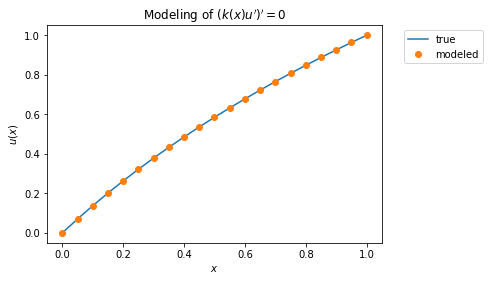

In [23]:
pts = np.linspace(0,1,n+1);
plt.plot(pts,[np.log(1+x)/np.log(2) for x in pts], label="true")
plt.plot(pts,x,'o', label="modeled")

plt.xlabel("$x$")
plt.ylabel("$u(x)$")
plt.title("Modeling of $(k(x)u')'=0$")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

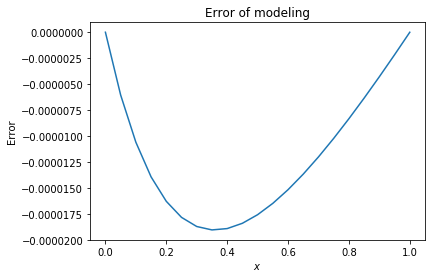

In [24]:
plt.plot(pts,x - [np.log(1+x)/np.log(2) for x in pts])

plt.xlabel("$x$")
plt.ylabel("Error")
plt.title("Error of modeling")
plt.show()